## Selection Phase: Initial Data Understanding and Feature Assessment

In [1]:
# Import necessary libraries
import pandas as pd

# Load the dataset
file_path = './data/BostonHousing.csv'
boston_df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [2]:
# Check for missing values
missing_values = boston_df.isnull().sum()

# Data types of the columns
data_types = boston_df.dtypes

# Summary statistics of the target variable 'medv'
target_variable_stats = boston_df['medv'].describe()

# Output results
missing_values, data_types, target_variable_stats

(crim       0
 zn         0
 indus      0
 chas       0
 nox        0
 rm         0
 age        0
 dis        0
 rad        0
 tax        0
 ptratio    0
 b          0
 lstat      0
 medv       0
 dtype: int64,
 crim       float64
 zn         float64
 indus      float64
 chas         int64
 nox        float64
 rm         float64
 age        float64
 dis        float64
 rad          int64
 tax          int64
 ptratio    float64
 b          float64
 lstat      float64
 medv       float64
 dtype: object,
 count    506.000000
 mean      22.532806
 std        9.197104
 min        5.000000
 25%       17.025000
 50%       21.200000
 75%       25.000000
 max       50.000000
 Name: medv, dtype: float64)

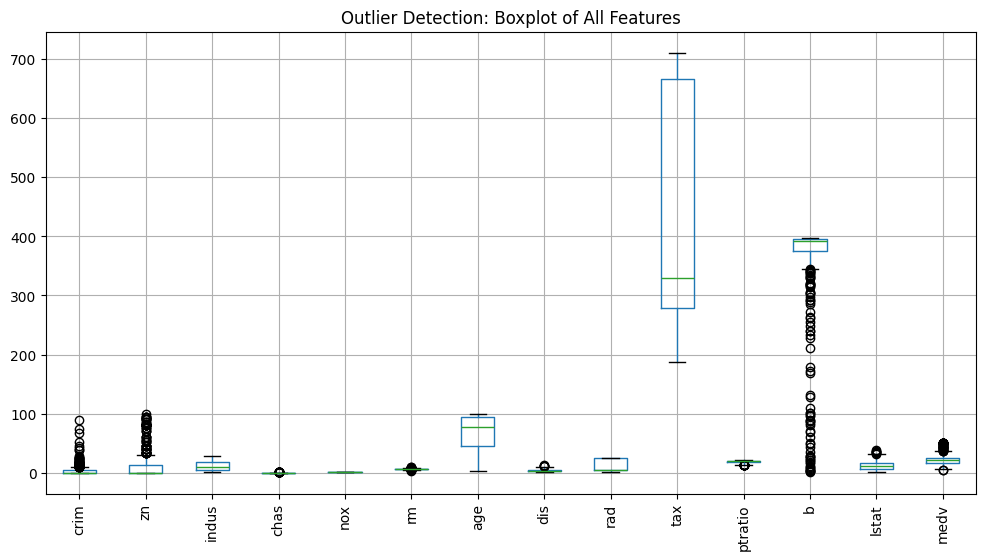

np.int64(16)

In [3]:
import matplotlib.pyplot as plt

# 1. Checking censoring in `medv`
censored_count = (boston_df['medv'] == 50).sum()

# 2. Outlier detection using boxplots
plt.figure(figsize=(12, 6))
boston_df.boxplot(rot=90)
plt.title('Outlier Detection: Boxplot of All Features')
plt.show()

# Output the censoring count
censored_count


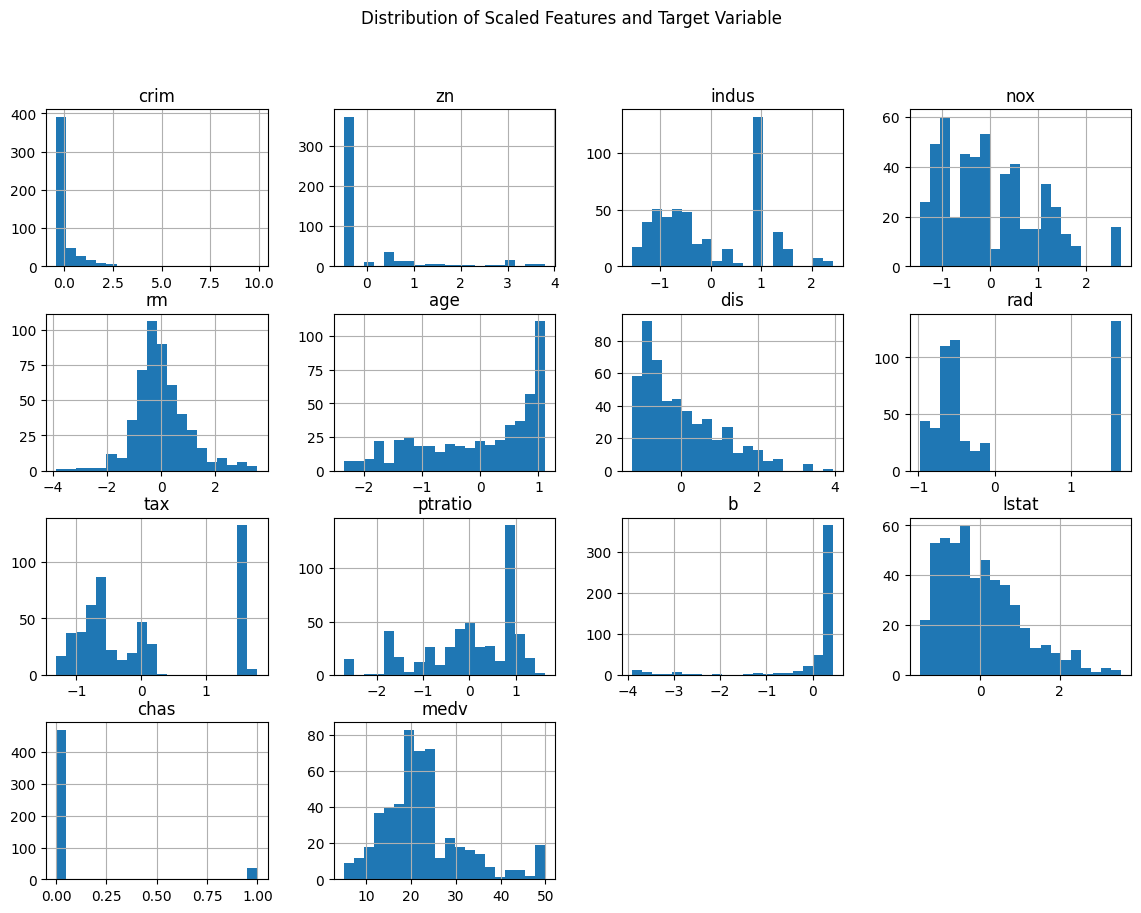

In [4]:
# 3. Standardizing the continuous features
from sklearn.preprocessing import StandardScaler

# Extract continuous features (excluding target and categorical 'chas')
continuous_features = boston_df.drop(columns=['medv', 'chas'])

scaler = StandardScaler()
boston_df_scaled = pd.DataFrame(scaler.fit_transform(continuous_features), columns=continuous_features.columns)

# Add 'chas' and 'medv' back into the dataframe
boston_df_scaled['chas'] = boston_df['chas']
boston_df_scaled['medv'] = boston_df['medv']

# 4. Distribution analysis (histograms)
boston_df_scaled.hist(bins=20, figsize=(14, 10))
plt.suptitle('Distribution of Scaled Features and Target Variable')
plt.show()


## Transformation Phase: Feature Engineering and Data Transformation

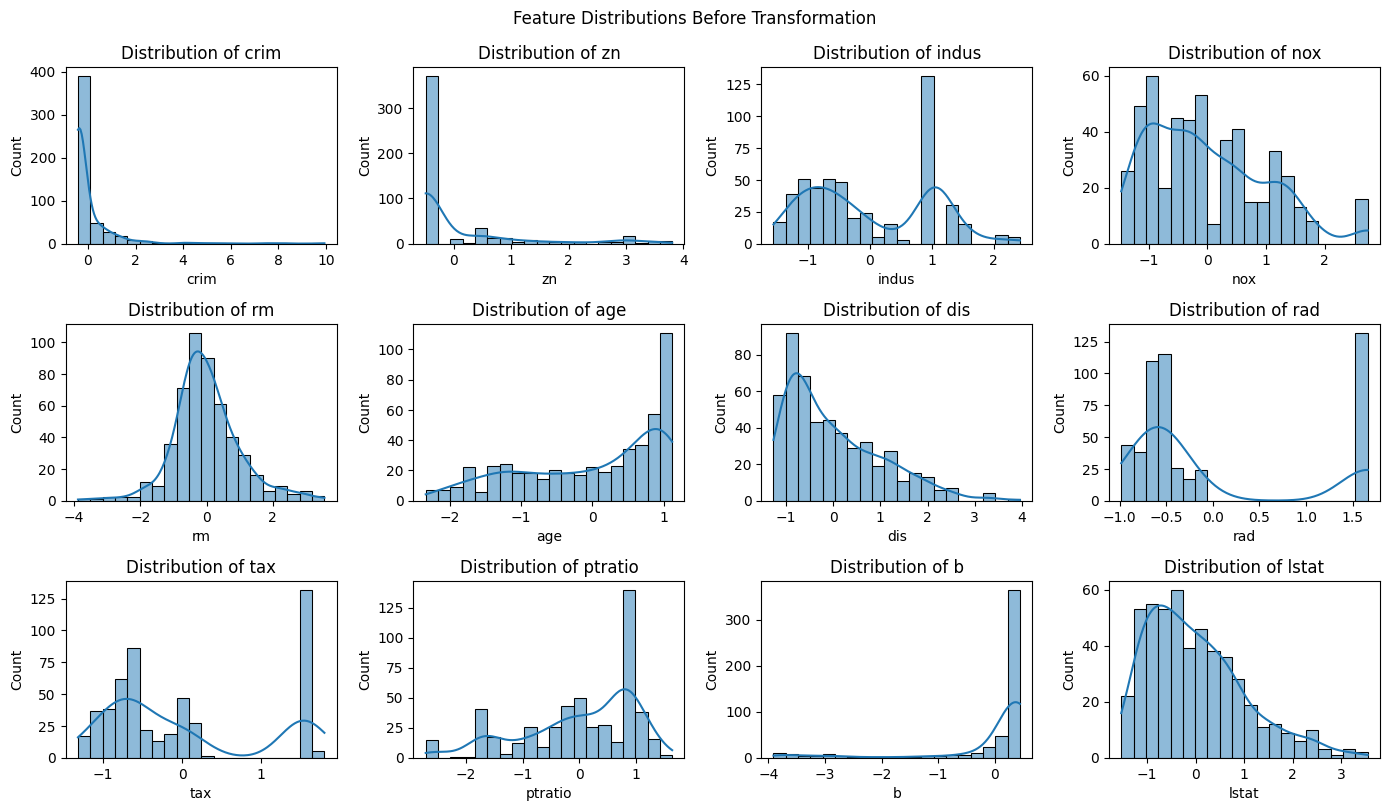

Skewed Features: ['crim', 'zn', 'dis', 'rad', 'ptratio', 'b', 'lstat']


In [5]:
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Analyze feature distributions to identify skewed features
plt.figure(figsize=(14, 10))
for idx, column in enumerate(boston_df_scaled.drop(columns=['medv', 'chas']).columns, 1):
    plt.subplot(4, 4, idx)
    sns.histplot(boston_df_scaled[column], kde=True, bins=20)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.suptitle('Feature Distributions Before Transformation', y=1.02)
plt.show()

# Calculate skewness
skewness = boston_df_scaled.drop(columns=['medv', 'chas']).skew()
skewed_features = skewness[abs(skewness) > 0.75].index.tolist()
print(f"Skewed Features: {skewed_features}")

In [6]:
# 2. Apply logarithmic transformation to skewed features
for feature in skewed_features:
    original_values = continuous_features[feature]  # Using original features before scaling
    transformed = np.log1p(original_values)  # log(1 + x) transformation to handle zero/negative values
    boston_df_scaled[f'{feature}_log'] = StandardScaler().fit_transform(transformed.values.reshape(-1, 1))

# 3. Feature Engineering: Creating interaction term between 'rm' and 'lstat'
boston_df_scaled['rm_lstat_interaction'] = boston_df_scaled['rm'] * boston_df_scaled['lstat']
boston_df_scaled['rm_lstat_interaction'] = StandardScaler().fit_transform(boston_df_scaled[['rm_lstat_interaction']])


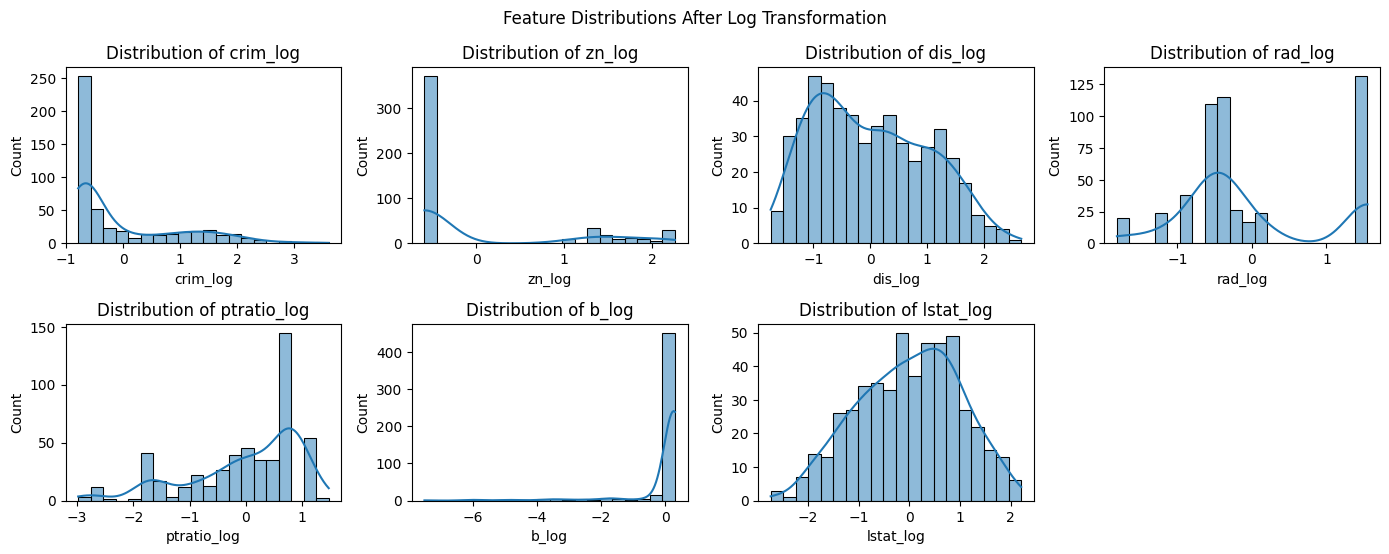

In [7]:
# 4. Dimensionality Reduction (Optional)
pca_features = boston_df_scaled.drop(columns=['medv', 'chas']).columns
pca = PCA(n_components=5)  # Choosing 5 components for illustration
principal_components = pca.fit_transform(boston_df_scaled[pca_features])
pca_columns = [f'PC{i}' for i in range(1, 6)]
pca_df = pd.DataFrame(data=principal_components, columns=pca_columns)

# Concatenate PCA components with categorical and target variables
boston_df_pca = pd.concat([pca_df, boston_df_scaled[['chas', 'medv']]], axis=1)

# Visualize transformed features
plt.figure(figsize=(14, 10))
for idx, column in enumerate(boston_df_scaled.filter(regex='_log').columns, 1):
    plt.subplot(4, 4, idx)
    sns.histplot(boston_df_scaled[column], kde=True, bins=20)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.suptitle('Feature Distributions After Log Transformation', y=1.02)
plt.show()

## Data Mining Phase: Model Selection and Comparison

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Split the dataset into training and testing sets
X = boston_df_scaled.drop(columns=['medv'])
y = boston_df_scaled['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Baseline Model: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions
y_pred_linear = linear_model.predict(X_test)

# Metrics
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Output the Linear Regression metrics
{
    'Linear Regression RMSE': rmse_linear,
    'Linear Regression MAE': mae_linear,
    'Linear Regression R-squared': r2_linear
}


d:\Education\Masters\Sem_1\CMPE-255-Data-Mining\Assignments\Python-Colab-CoPilot-Akkio\Assignment-2\backend\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'Linear Regression RMSE': np.float64(3.778378254829541),
 'Linear Regression MAE': np.float64(2.5178932702542682),
 'Linear Regression R-squared': 0.8053265272656382}

In [9]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# 3. Advanced Models: Ridge, Lasso, Random Forest, Gradient Boosting
ridge_model = Ridge()
lasso_model = Lasso()
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Cross-validation for advanced models (negative RMSE)
cv_ridge = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_lasso = cross_val_score(lasso_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_rf = cross_val_score(rf_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_gb = cross_val_score(gb_model, X, y, cv=5, scoring='neg_root_mean_squared_error')

# Output the CV results
{
    'Ridge CV RMSE': -cv_ridge.mean(),
    'Lasso CV RMSE': -cv_lasso.mean(),
    'Random Forest CV RMSE': -cv_rf.mean(),
    'Gradient Boosting CV RMSE': -cv_gb.mean()
}


{'Ridge CV RMSE': np.float64(4.956985640202947),
 'Lasso CV RMSE': np.float64(5.449761628365357),
 'Random Forest CV RMSE': np.float64(4.458948805985022),
 'Gradient Boosting CV RMSE': np.float64(4.157248504072782)}

## Hyperparameter Tuning and Model Interpretation

In [10]:
from sklearn.model_selection import GridSearchCV

# 1. Hyperparameter Tuning for Ridge, Lasso, Random Forest, and Gradient Boosting

# Define parameter grids for each model
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV for each model
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_root_mean_squared_error')
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_root_mean_squared_error')
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_root_mean_squared_error')
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5, scoring='neg_root_mean_squared_error')

# Fit the models
ridge_grid.fit(X_train, y_train)
lasso_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)

# Get the best parameters and scores for each model
best_params_ridge = ridge_grid.best_params_
best_params_lasso = lasso_grid.best_params_
best_params_rf = rf_grid.best_params_
best_params_gb = gb_grid.best_params_

best_score_ridge = -ridge_grid.best_score_
best_score_lasso = -lasso_grid.best_score_
best_score_rf = -rf_grid.best_score_
best_score_gb = -gb_grid.best_score_

# Output the best parameters and scores
{
    'Best Ridge Params': best_params_ridge,
    'Best Ridge RMSE': best_score_ridge,
    'Best Lasso Params': best_params_lasso,
    'Best Lasso RMSE': best_score_lasso,
    'Best Random Forest Params': best_params_rf,
    'Best Random Forest RMSE': best_score_rf,
    'Best Gradient Boosting Params': best_params_gb,
    'Best Gradient Boosting RMSE': best_score_gb
}


d:\Education\Masters\Sem_1\CMPE-255-Data-Mining\Assignments\Python-Colab-CoPilot-Akkio\Assignment-2\backend\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.907e+01, tolerance: 2.882e+00
  model = cd_fast.enet_coordinate_descent(
d:\Education\Masters\Sem_1\CMPE-255-Data-Mining\Assignments\Python-Colab-CoPilot-Akkio\Assignment-2\backend\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.165e+00, tolerance: 2.710e+00
  model = cd_fast.enet_coordinate_descent(
d:\Education\Masters\Sem_1\CMPE-255-Data-Mining\Assignments\Python-Colab-CoPilot-Akkio\Assignment-2\backend\.venv\lib\

{'Best Ridge Params': {'alpha': 10},
 'Best Ridge RMSE': np.float64(4.123980543766972),
 'Best Lasso Params': {'alpha': 0.01},
 'Best Lasso RMSE': np.float64(4.157259442072316),
 'Best Random Forest Params': {'max_depth': 15,
  'min_samples_split': 2,
  'n_estimators': 100},
 'Best Random Forest RMSE': np.float64(3.8092920541283606),
 'Best Gradient Boosting Params': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 100},
 'Best Gradient Boosting RMSE': np.float64(3.496756153973948)}

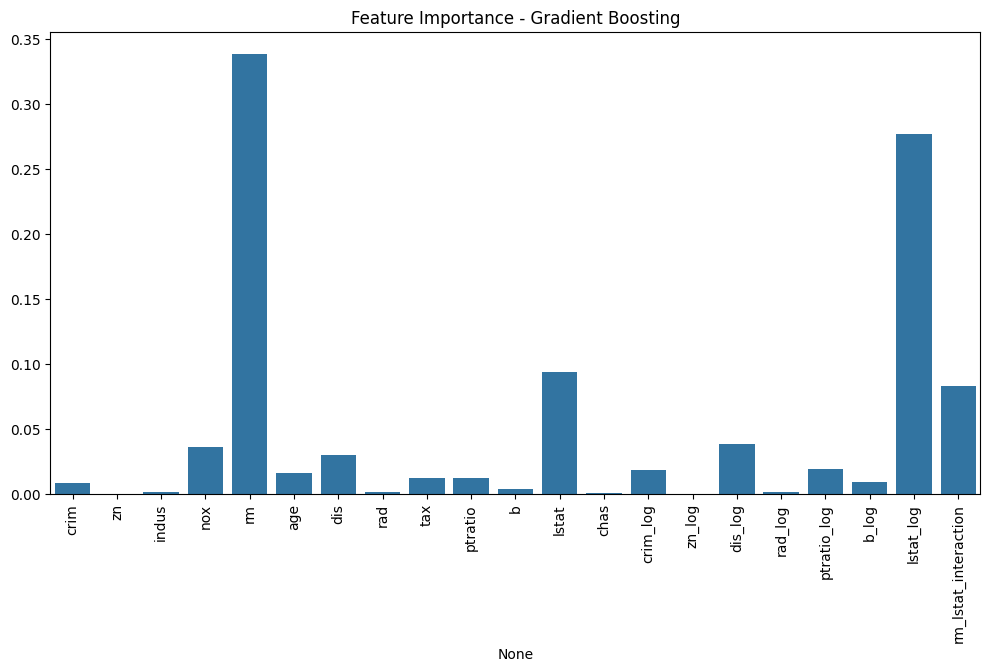

In [11]:
# 2. Feature Importance for the best tree-based model (Gradient Boosting)

# Assuming Gradient Boosting performed the best
best_gb_model = gb_grid.best_estimator_
feature_importances = best_gb_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=X_train.columns, y=feature_importances)
plt.xticks(rotation=90)
plt.title('Feature Importance - Gradient Boosting')
plt.show()


In [12]:
# 1. Evaluate the best model on the test set (Assuming the best model is Gradient Boosting)
best_model = gb_grid.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Output final performance metrics
{
    'Test Set RMSE': rmse_test,
    'Test Set MAE': mae_test,
    'Test Set R-squared': r2_test
}


d:\Education\Masters\Sem_1\CMPE-255-Data-Mining\Assignments\Python-Colab-CoPilot-Akkio\Assignment-2\backend\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'Test Set RMSE': np.float64(2.5555293401510224),
 'Test Set MAE': np.float64(1.9377102084294302),
 'Test Set R-squared': 0.9109451343305829}

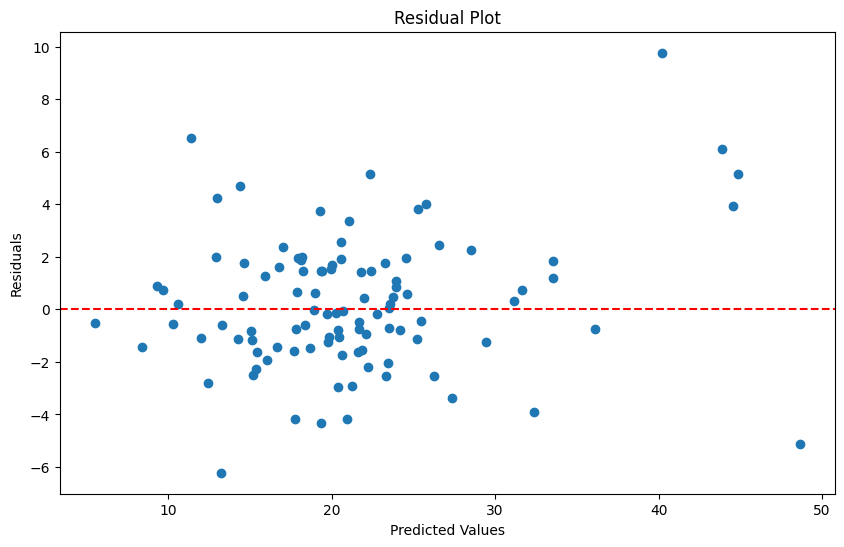

In [13]:
# 2. Residual analysis

residuals = y_test - y_pred

# Plot residuals to check for any patterns
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
